In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()

# device = torch.device('cpu')
device = None
if use_gpu:
    device = torch.device('cuda:0')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")
    
torch.manual_seed(54)

Using CUDA


In [2]:
# !pip install gputil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()  

 # ****Data preprocessing****

In [3]:
df = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df.describe()

,Follow-up #,Patient ID,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [5]:
df.count()

Image Index                    112120
Finding Labels                 112120
Follow-up #                    112120
Patient ID                     112120
Patient Age                    112120
Patient Gender                 112120
View Position                  112120
OriginalImage[Width            112120
Height]                        112120
OriginalImagePixelSpacing[x    112120
y]                             112120
Unnamed: 11                         0
dtype: int64

In [6]:
df[df['Image Index'].isna()].count()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Unnamed: 11                    0
dtype: int64

In [7]:
df[df['Finding Labels'] == 'No Finding'].count()

Image Index                    60412
Finding Labels                 60412
Follow-up #                    60412
Patient ID                     60412
Patient Age                    60412
Patient Gender                 60412
View Position                  60412
OriginalImage[Width            60412
Height]                        60412
OriginalImagePixelSpacing[x    60412
y]                             60412
Unnamed: 11                        0
dtype: int64

In [8]:
df = df.drop(df[df['Finding Labels'] == 'No Finding'].index)

In [9]:
labels = ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis',
          'hernia', 'infiltration', 'mass', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']

In [10]:
labels

['atelectasis',
 'cardiomegaly',
 'consolidation',
 'edema',
 'effusion',
 'emphysema',
 'fibrosis',
 'hernia',
 'infiltration',
 'mass',
 'nodule',
 'pleural_thickening',
 'pneumonia',
 'pneumothorax']

In [11]:
len(labels)

14

In [12]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,074Y,F,PA,2500,2048,0.168,0.168,NaN


In [13]:
df = df.drop(df.columns.difference(['Image Index', 'Finding Labels']), axis=1)

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
label_mlb = []
for label in df['Finding Labels'].values:
    splits = label.split('|')
    label_mlb.append(set(splits))

mlb = MultiLabelBinarizer()
label_array = mlb.fit_transform(label_mlb)

In [15]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [16]:
final_df = pd.DataFrame(label_array, columns=mlb.classes_)
final_df.insert(loc=0, column='Image', value=df['Image Index'].values)
final_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#  Creating dataset

In [17]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [18]:

class ChestXRayDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        
        file = open(self.root)
        images = file.read().splitlines()
        
        ids = []
        
        for idx, path in enumerate(self.df['Image']):
            if path in images:
                ids.append(idx)
        
        self.df = self.df.iloc[ids, :].reset_index(drop=True)
        self.images = self.df['Image'].values
        self.labels = self.df.iloc[:, 1:].values
    
        labels = list(map(lambda x: x.lower(), self.df.columns[1:]))
        self.classes = {v: k for k, v in enumerate(labels)}
        
    def __getitem__(self, item):
        img = Image.open(
            f'/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/{self.images[item]}'
        )
#         img = np.expand_dims(img, axis=-1)
#         img = img.repeat(3, axis=-1)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, torch.tensor(self.labels[item], dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)

In [19]:
basic_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(num_output_channels=3), 
                                          torchvision.transforms.Resize((299, 299)),
                                          torchvision.transforms.ToTensor()
                                          ])

In [20]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [21]:
test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [22]:
len(train_dataset), train_dataset[0]

(36024,
 (tensor([[[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.

# Dealing with class imbalance

In [23]:
len(train_dataset)

36024

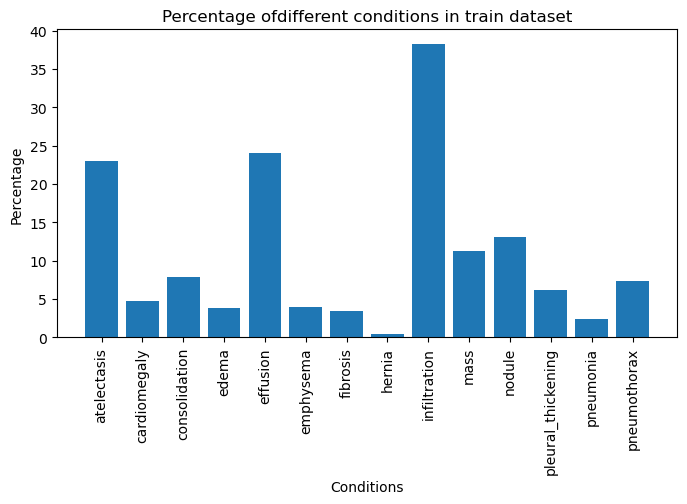

In [24]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_27/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


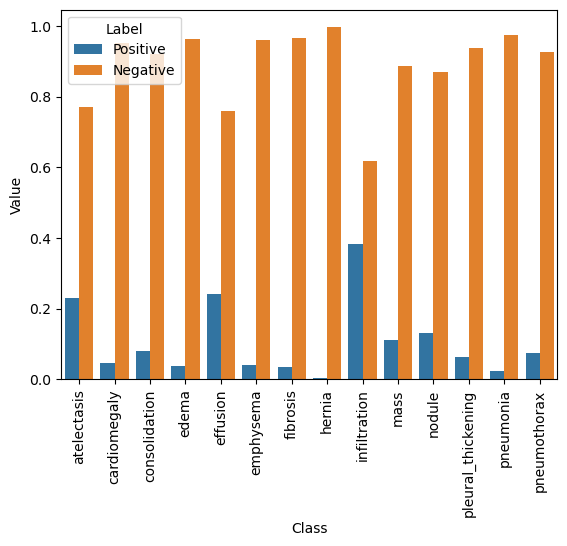

In [25]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_27/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


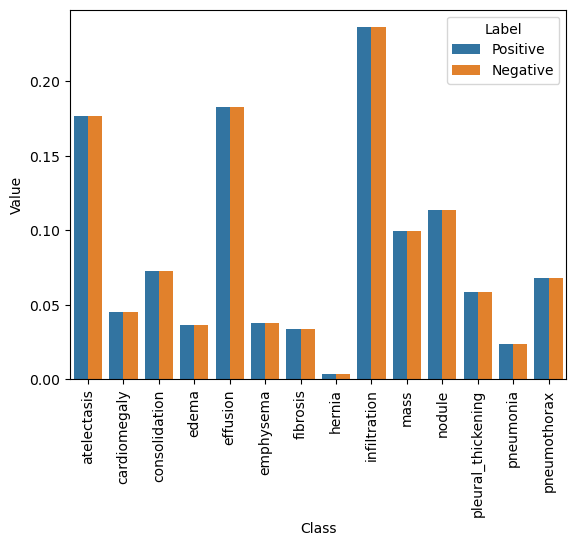

In [26]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [27]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

In [28]:
# cr = WeightedLoss()
# cr(torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], 
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]),
#    torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]))

In [29]:
import random

from torch.utils.data.sampler import Sampler


class MultilabelBalancedRandomSampler(Sampler):
    """
    MultilabelBalancedRandomSampler: Given a multilabel dataset of length n_samples and
    number of classes n_classes, samples from the data with equal probability per class
    effectively oversampling minority classes and undersampling majority classes at the
    same time. Note that using this sampler does not guarantee that the distribution of
    classes in the output samples will be uniform, since the dataset is multilabel and
    sampling is based on a single class. This does however guarantee that all classes
    will have at least batch_size / n_classes samples as batch_size approaches infinity
    """

    def __init__(self, labels, indices=None, class_choice="least_sampled"):
        """
        Parameters:
        -----------
            labels: a multi-hot encoding numpy array of shape (n_samples, n_classes)
            indices: an arbitrary-length 1-dimensional numpy array representing a list
            of indices to sample only from
            class_choice: a string indicating how class will be selected for every
            sample:
                "least_sampled": class with the least number of sampled labels so far
                "random": class is chosen uniformly at random
                "cycle": the sampler cycles through the classes sequentially
        """
        self.labels = labels
        self.indices = indices
        # print(self.labels)
        if self.indices is None:
            self.indices = range(len(labels))

        self.num_classes = self.labels.shape[1]

        # List of lists of example indices per class
        self.class_indices = []
        for class_ in range(self.num_classes):
            lst = np.where(self.labels[:, class_] == 1)[0]
            lst = lst[np.isin(lst, self.indices)]
            self.class_indices.append(lst)

        self.counts = [0] * self.num_classes
        # print(self.counts)
        assert class_choice in ["least_sampled", "random", "cycle"]
        self.class_choice = class_choice
        self.current_class = 0
        # print(self.class_indices)

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count >= len(self.indices):
            raise StopIteration
        self.count += 1
        return self.sample()

    def sample(self):
        class_ = self.get_class()
        class_indices = self.class_indices[class_]
        chosen_index = np.random.choice(class_indices)
        if self.class_choice == "least_sampled":
            for class_, indicator in enumerate(self.labels[chosen_index]):
                if indicator == 1:
                    self.counts[class_] += 1
        return chosen_index

    def get_class(self):
        if self.class_choice == "random":
            class_ = random.randint(0, self.labels.shape[1] - 1)
        elif self.class_choice == "cycle":
            class_ = self.current_class
            self.current_class = (self.current_class + 1) % self.labels.shape[1]
        elif self.class_choice == "least_sampled":
            min_count = self.counts[0]
            min_classes = [0]
            for class_ in range(1, self.num_classes):
                if self.counts[class_] < min_count:
                    min_count = self.counts[class_]
                    min_classes = [class_]
                if self.counts[class_] == min_count:
                    min_classes.append(class_)
            class_ = np.random.choice(min_classes)
        return class_

    def __len__(self):
        return len(self.indices)

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

BATCH_SIZE = 32
LEARNING_RATE = 1e-6
PIN_MEMORY = False
EPOCHS = 10
THRESHOLD = 0.5

In [31]:
print(DEVICE)

cuda


In [32]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    sampler=MultilabelBalancedRandomSampler(train_dataset.labels),
    drop_last=False,
)

In [33]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

# Training the VGG16 model

In [34]:
def train_epoch(loader, model, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    i = 0
    running_loss = 0.
    for images, labels, in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        i += 1
        
    print(f'=> Epoch[{epoch}]: Mean Loss = {np.mean(losses)}')
    torch.save(model.state_dict(), f'./weighted_bce_loss_weights{epoch}.pt')
    
    return np.mean(losses)

In [81]:
vgg = torchvision.models.vgg16_bn(pretrained=True)
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=14, bias=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 189MB/s]  


In [37]:
# vgg16.classifier.add_module('7', nn.Sigmoid())

In [ ]:
# model.add_module('Sigmoid', nn.Sigmoid())

In [82]:
vgg.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [83]:
optimizer = optim.Adam(vgg.parameters(), lr=LEARNING_RATE)
loss_fn = WeightedLoss()

# Using balanced accuracy for each sample as a metric

In [35]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import precision_score, recall_score

def get_classes_accuracy_and_pr(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for i in range(len(outputs[0])):
        bal_acc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
        total_balanced_acc.append(bal_acc)
        
        precision = precision_score(y_true[:, i], y_pred[:, i])
        precision_scores.append(precision)
        
        recall = recall_score(y_true[:, i], y_pred[:, i])
        recall_scores.append(recall)
        
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1)
        
#         cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=mlb.classes)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                       display_labels=mlb.classes)
#         disp.plot()
            
#             bal_acc = balanced_accuracy_score(np_labels[:, i], np_outputs[:, i])
#             batch_balanced_accuracies.append(bal_acc)
#         total_balanced_acc.append(batch_balanced_accuracies)
    
#     mean_acc = np.mean(total_balanced_acc, axis=0)
#     print(len(total_balanced_acc))
#     print(mean_acc)
    return total_balanced_acc, precision_scores, recall_scores, f1_scores

In [35]:
# get_classes_accuracy(test_loader, model)

In [85]:
with torch.no_grad():
    class_accuracies_pretrained_vgg, precisions_pretrained_vgg, recalls_pretrained_vgg = get_classes_accuracy_and_pr(test_loader, vgg)
    print(f'accuracies: {class_accuracies_pretrained_vgg}')
    print(f'mean accuracy: {np.mean(class_accuracies_pretrained_vgg)}\n')

    print(f'precisions: {precisions_pretrained_vgg}')
    print(f'mean precision: {np.mean(precisions_pretrained_vgg)}\n')

    print(f'recalls: {recalls_pretrained_vgg}')
    print(f'mean recall: {np.mean(recalls_pretrained_vgg)}\n')

100%|██████████| 981/981 [02:46<00:00,  5.91it/s]


accuracies: [0.4868781313807125, 0.49820299455946293, 0.5106768826844339, 0.5002047674071524, 0.4887917667667512, 0.5003945331450794, 0.5789064743646276, 0.5905706456104987, 0.4994394086125461, 0.5103105911422311, 0.489206601607689, 0.4995721212587234, 0.5027197008329084, 0.49696231651900924]
mean accuracy: 0.5109169239922733

precisions: [0.20278148486338415, 0.06767495513970777, 0.143317230273752, 0.05900006385288296, 0.2856517296745001, 0.07046332046332046, 0.0453227931488801, 0.007271468144044321, 0.38789714506670103, 0.14364035087719298, 0.08500861573808156, 0.07281894185972301, 0.030576473643209555, 0.10152284263959391]
mean precision: 0.12163910109892671

recalls: [0.8869431643625192, 0.9915492957746479, 0.09807162534435261, 0.9989189189189189, 0.42104130808950085, 0.06678865507776761, 0.3954022988505747, 0.7325581395348837, 0.9886662286465178, 0.07651869158878505, 0.09164086687306501, 0.9982502187226596, 0.9874213836477987, 0.00751597143930853]
mean recall: 0.5529490547765215



In [87]:
f1_pretrained_vgg = []    
for i in range(n_classes):
    f1_pretrained_vgg.append(2 * precisions_pretrained_vgg[i] * recalls_pretrained_vgg[i] / (precisions_pretrained_vgg[i] + recalls_pretrained_vgg[i]))

In [98]:
# model.load_state_dict(torch.load('/kaggle/working/weighted_bce_loss_weights11.pt'))

<All keys matched successfully>

In [89]:
vgg_losses = []

vgg_class_accs = torch.load('/kaggle/working/vgg_class_accuracies_by_epochs.pt')
vgg_mean_accs = torch.load('/kaggle/working/vgg_mean_accuracies_by_epochs.pt')

vgg_class_recs = torch.load('/kaggle/working/vgg_class_recs_by_epochs.pt')
vgg_mean_recs = torch.load('/kaggle/working/vgg_mean_recs_by_epochs.pt')

vgg_class_precs = torch.load('/kaggle/working/vgg_class_precs_by_epochs.pt')
vgg_mean_precs = torch.load('/kaggle/working/vgg_mean_precs_by_epochs.pt')

In [104]:
vgg.load_state_dict(torch.load('/kaggle/working/vgg_weights_rec0.4800676482874114_acc0.6470800079416291%.pt'))

<All keys matched successfully>

In [105]:
#epochs 7 - 10
for epoch in range(4):
    loss = train_epoch(
        train_loader,
        vgg,
        optimizer,
        loss_fn,
        epoch + 1
    )
    
    with torch.no_grad():
        accs, precs, recs = get_classes_accuracy_and_pr(test_loader, vgg)
        print(f'epoch {epoch + 1} classes balanced accuracies:')
        print(f'accuracies: {accs}')
        print(f'mean accuracy: {np.mean(accs)}\n')
        
        print(f'precisions: {precs}')
        print(f'mean precision: {np.mean(precs)}\n')
        
        print(f'recalls: {recs}')
        print(f'mean recall: {np.mean(recs)}\n')
        
        vgg_class_accs.append(accs)
        vgg_mean_accs.append(np.mean(accs))
        
        vgg_class_precs.append(precs)
        vgg_mean_precs.append(np.mean(precs))
        
        vgg_class_recs.append(recs)
        vgg_mean_recs.append(np.mean(recs))
        
        torch.save(vgg_class_accs, './vgg_class_accuracies_by_epochs.pt')
        torch.save(vgg_mean_accs, './vgg_mean_accuracies_by_epochs.pt')
        torch.save(vgg_class_precs, './vgg_class_precs_by_epochs.pt')
        torch.save(vgg_mean_precs, './vgg_mean_precs_by_epochs.pt')
        torch.save(vgg_class_recs, './vgg_class_recs_by_epochs.pt')
        torch.save(vgg_mean_recs, './vgg_mean_recs_by_epochs.pt')
    
        torch.save(vgg.state_dict(), f'./vgg_weights_rec{np.mean(recs)}_acc{np.mean(accs)}%.pt')
        
    vgg_losses.append(loss)

  4%|▍         | 50/1126 [00:34<12:27,  1.44it/s]

  batch 50 loss: 0.21147337749600412


  9%|▉         | 100/1126 [01:09<11:53,  1.44it/s]

  batch 100 loss: 0.1947202841937542


 13%|█▎        | 150/1126 [01:44<11:03,  1.47it/s]

  batch 150 loss: 0.1953741966187954


 18%|█▊        | 200/1126 [02:19<10:36,  1.45it/s]

  batch 200 loss: 0.1703006936609745


 22%|██▏       | 250/1126 [02:53<09:56,  1.47it/s]

  batch 250 loss: 0.16973885923624038


 27%|██▋       | 300/1126 [03:27<09:23,  1.47it/s]

  batch 300 loss: 0.17509721085429192


 31%|███       | 350/1126 [04:02<09:09,  1.41it/s]

  batch 350 loss: 0.15887657985091208


 36%|███▌      | 400/1126 [04:36<08:28,  1.43it/s]

  batch 400 loss: 0.1775535127520561


 40%|███▉      | 450/1126 [05:11<07:48,  1.44it/s]

  batch 450 loss: 0.15524725154042243


 44%|████▍     | 500/1126 [05:45<07:07,  1.46it/s]

  batch 500 loss: 0.16165898129343986


 49%|████▉     | 550/1126 [06:20<06:32,  1.47it/s]

  batch 550 loss: 0.16055298380553723


 53%|█████▎    | 600/1126 [06:54<05:58,  1.47it/s]

  batch 600 loss: 0.15696384280920028


 58%|█████▊    | 650/1126 [07:29<05:27,  1.45it/s]

  batch 650 loss: 0.15617409229278564


 62%|██████▏   | 700/1126 [08:03<04:53,  1.45it/s]

  batch 700 loss: 0.15084497474133968


 67%|██████▋   | 750/1126 [08:37<04:16,  1.46it/s]

  batch 750 loss: 0.1493964845687151


 71%|███████   | 800/1126 [09:12<03:42,  1.47it/s]

  batch 800 loss: 0.17715226732194422


 75%|███████▌  | 850/1126 [09:46<03:11,  1.44it/s]

  batch 850 loss: 0.1559610926359892


 80%|███████▉  | 900/1126 [10:21<02:44,  1.38it/s]

  batch 900 loss: 0.14695188574492932


 84%|████████▍ | 950/1126 [10:55<02:00,  1.46it/s]

  batch 950 loss: 0.12742539562284946


 89%|████████▉ | 1000/1126 [11:30<01:26,  1.46it/s]

  batch 1000 loss: 0.14879345744848252


 93%|█████████▎| 1050/1126 [12:04<00:51,  1.48it/s]

  batch 1050 loss: 0.13777549162507058


 98%|█████████▊| 1100/1126 [12:38<00:17,  1.47it/s]

  batch 1100 loss: 0.16319760926067828


100%|██████████| 1126/1126 [12:56<00:00,  1.45it/s]


=> Epoch[1]: Mean Loss = 0.16288664922462265


100%|██████████| 981/981 [02:46<00:00,  5.88it/s]


epoch 1 classes balanced accuracies:
accuracies: [0.5771343442736309, 0.7374420130468837, 0.6062872247935076, 0.6934419859252166, 0.658750364165719, 0.7732831459415851, 0.6167637900506759, 0.682820844652117, 0.5636014294173164, 0.6697400976853574, 0.630945052546197, 0.6292411302930027, 0.5152476536583409, 0.7333296627828954]
mean accuracy: 0.6491449099451747

precisions: [0.37536904259805987, 0.31878658861096326, 0.16301635708344886, 0.1562229280970257, 0.5190905190905191, 0.3419892209701127, 0.12144212523719165, 0.10476190476190476, 0.5149892933618844, 0.23439767779390422, 0.20273468314488563, 0.14389421830438165, 0.044760935910478125, 0.40017885088307625]
mean precision: 0.2601167389891311

recalls: [0.27342549923195086, 0.5624413145539906, 0.6479338842975206, 0.5848648648648649, 0.5206540447504303, 0.6386093321134492, 0.2942528735632184, 0.38372093023255816, 0.3160315374507227, 0.5660046728971962, 0.4773993808049536, 0.48556430446194226, 0.09224318658280922, 0.6726794438181135]
mean

  4%|▍         | 50/1126 [00:35<12:42,  1.41it/s]

  batch 50 loss: 0.13534083120524884


  9%|▉         | 100/1126 [01:09<11:48,  1.45it/s]

  batch 100 loss: 0.1458037259429693


 13%|█▎        | 150/1126 [01:44<11:20,  1.43it/s]

  batch 150 loss: 0.13840204298496248


 18%|█▊        | 200/1126 [02:19<10:39,  1.45it/s]

  batch 200 loss: 0.12069609999656677


 22%|██▏       | 250/1126 [02:53<10:02,  1.45it/s]

  batch 250 loss: 0.13042045094072818


 27%|██▋       | 300/1126 [03:28<09:26,  1.46it/s]

  batch 300 loss: 0.12880628630518914


 31%|███       | 350/1126 [04:03<09:14,  1.40it/s]

  batch 350 loss: 0.11858098044991493


 36%|███▌      | 400/1126 [04:38<08:22,  1.45it/s]

  batch 400 loss: 0.13579644933342933


 40%|███▉      | 450/1126 [05:12<07:45,  1.45it/s]

  batch 450 loss: 0.12812951304018497


 44%|████▍     | 500/1126 [05:47<07:16,  1.43it/s]

  batch 500 loss: 0.11940418779850007


 49%|████▉     | 550/1126 [06:22<06:35,  1.46it/s]

  batch 550 loss: 0.1244364308565855


 53%|█████▎    | 600/1126 [06:56<06:00,  1.46it/s]

  batch 600 loss: 0.10396894782781602


 58%|█████▊    | 650/1126 [07:31<05:26,  1.46it/s]

  batch 650 loss: 0.1269109934568405


 62%|██████▏   | 700/1126 [08:06<04:57,  1.43it/s]

  batch 700 loss: 0.11258830718696117


 67%|██████▋   | 750/1126 [08:40<04:20,  1.44it/s]

  batch 750 loss: 0.10790995091199874


 71%|███████   | 800/1126 [09:15<03:47,  1.44it/s]

  batch 800 loss: 0.10532435901463032


 75%|███████▌  | 850/1126 [09:50<03:15,  1.42it/s]

  batch 850 loss: 0.12760424602776765


 80%|███████▉  | 900/1126 [10:24<02:36,  1.45it/s]

  batch 900 loss: 0.12737769439816474


 84%|████████▍ | 950/1126 [10:59<02:04,  1.41it/s]

  batch 950 loss: 0.10498876761645079


 89%|████████▉ | 1000/1126 [11:33<01:26,  1.46it/s]

  batch 1000 loss: 0.13764872647821902


 93%|█████████▎| 1050/1126 [12:08<00:52,  1.46it/s]

  batch 1050 loss: 0.10305121161043644


 98%|█████████▊| 1100/1126 [12:42<00:17,  1.46it/s]

  batch 1100 loss: 0.11837506182491779


100%|██████████| 1126/1126 [13:00<00:00,  1.44it/s]


=> Epoch[2]: Mean Loss = 0.1224131942420642


100%|██████████| 981/981 [02:44<00:00,  5.95it/s]


epoch 2 classes balanced accuracies:
accuracies: [0.5775915773019321, 0.7345972682665527, 0.601915145794563, 0.6944583149447978, 0.6571658143993153, 0.769675067593272, 0.6048360435167032, 0.668424246400105, 0.5598279561293333, 0.6727692701825547, 0.6300067095234082, 0.6269339604676505, 0.5110125964002841, 0.7321206752323809]
mean accuracy: 0.6458096175823467

precisions: [0.3741156887224303, 0.3331435079726651, 0.16341107871720117, 0.15758811535100495, 0.5217010083296799, 0.3601694915254237, 0.1248630887185104, 0.1382488479262673, 0.5099754031156054, 0.2477643345607575, 0.20363442009620525, 0.15007173601147777, 0.04342273307790549, 0.4140066698427823]
mean precision: 0.26729400885485116

recalls: [0.2761904761904762, 0.5492957746478874, 0.6176308539944904, 0.5848648648648649, 0.5120481927710844, 0.6221408966148216, 0.2620689655172414, 0.3488372093023256, 0.30650459921156376, 0.5502336448598131, 0.4718266253869969, 0.4575678040244969, 0.07127882599580712, 0.6531379180759113]
mean recall

  4%|▍         | 50/1126 [00:34<12:27,  1.44it/s]

  batch 50 loss: 0.11140895135700703


  9%|▉         | 100/1126 [01:09<12:02,  1.42it/s]

  batch 100 loss: 0.10618732757866382


 13%|█▎        | 150/1126 [01:45<11:20,  1.43it/s]

  batch 150 loss: 0.13031283389776946


 18%|█▊        | 200/1126 [02:20<10:58,  1.41it/s]

  batch 200 loss: 0.11110470198094845


 22%|██▏       | 250/1126 [02:55<10:33,  1.38it/s]

  batch 250 loss: 0.11296695612370967


 27%|██▋       | 300/1126 [03:30<09:39,  1.42it/s]

  batch 300 loss: 0.10945178292691708


 31%|███       | 350/1126 [04:05<09:06,  1.42it/s]

  batch 350 loss: 0.11139030568301678


 36%|███▌      | 400/1126 [04:40<08:25,  1.44it/s]

  batch 400 loss: 0.1048694109171629


 40%|███▉      | 450/1126 [05:15<07:55,  1.42it/s]

  batch 450 loss: 0.11261116974055767


 44%|████▍     | 500/1126 [05:50<07:10,  1.45it/s]

  batch 500 loss: 0.1122506808489561


 49%|████▉     | 550/1126 [06:25<06:37,  1.45it/s]

  batch 550 loss: 0.10621240079402923


 53%|█████▎    | 600/1126 [06:59<06:03,  1.45it/s]

  batch 600 loss: 0.1151324287801981


 58%|█████▊    | 650/1126 [07:34<05:29,  1.45it/s]

  batch 650 loss: 0.12013812508434057


 62%|██████▏   | 700/1126 [08:09<05:11,  1.37it/s]

  batch 700 loss: 0.0869573862105608


 67%|██████▋   | 750/1126 [08:44<04:22,  1.43it/s]

  batch 750 loss: 0.12449075274169445


 71%|███████   | 800/1126 [09:19<03:47,  1.43it/s]

  batch 800 loss: 0.10608697339892387


 75%|███████▌  | 850/1126 [09:54<03:11,  1.44it/s]

  batch 850 loss: 0.10394112959504127


 80%|███████▉  | 900/1126 [10:29<02:37,  1.43it/s]

  batch 900 loss: 0.11620516948401928


 84%|████████▍ | 950/1126 [11:03<02:00,  1.46it/s]

  batch 950 loss: 0.09394334271550178


 89%|████████▉ | 1000/1126 [11:38<01:26,  1.45it/s]

  batch 1000 loss: 0.10847707740962505


 93%|█████████▎| 1050/1126 [12:12<00:52,  1.45it/s]

  batch 1050 loss: 0.0950462869554758


 98%|█████████▊| 1100/1126 [12:47<00:18,  1.43it/s]

  batch 1100 loss: 0.09508247882127761


100%|██████████| 1126/1126 [13:05<00:00,  1.43it/s]


=> Epoch[3]: Mean Loss = 0.10856103788578278


100%|██████████| 981/981 [02:45<00:00,  5.92it/s]


epoch 3 classes balanced accuracies:
accuracies: [0.5702030297064284, 0.735256452870035, 0.5955155352713019, 0.6951185076261301, 0.6566423749157038, 0.7669955404335964, 0.6007283688472506, 0.6584632197926389, 0.5619784018089009, 0.6707687738628124, 0.6275332962024626, 0.6232071465587123, 0.508705648218112, 0.7273352383836384]
mean accuracy: 0.6427465381784089

precisions: [0.38446507083536885, 0.33914053426248547, 0.16436617483737903, 0.1642392314843508, 0.540366753989045, 0.37235228539576365, 0.12703962703962704, 0.17177914110429449, 0.5160664819944598, 0.2502030869212023, 0.19774301102846883, 0.1493411420204978, 0.04333868378812199, 0.42277651801461325]
mean precision: 0.27451555305111985

recalls: [0.24178187403993856, 0.5483568075117371, 0.5707988980716253, 0.572972972972973, 0.48816695352839934, 0.6111619396157365, 0.25057471264367814, 0.32558139534883723, 0.30601182654402104, 0.5397196261682243, 0.4773993808049536, 0.4461942257217848, 0.05660377358490566, 0.6305900037579857]
mean

  4%|▍         | 50/1126 [00:35<12:23,  1.45it/s]

  batch 50 loss: 0.11358451768755913


  9%|▉         | 100/1126 [01:10<11:53,  1.44it/s]

  batch 100 loss: 0.09332506597042084


 13%|█▎        | 150/1126 [01:45<11:44,  1.38it/s]

  batch 150 loss: 0.09448372408747673


 18%|█▊        | 200/1126 [02:20<10:47,  1.43it/s]

  batch 200 loss: 0.09863129485398531


 22%|██▏       | 250/1126 [02:55<10:10,  1.44it/s]

  batch 250 loss: 0.09545509975403547


 27%|██▋       | 300/1126 [03:30<09:31,  1.45it/s]

  batch 300 loss: 0.0869541047513485


 31%|███       | 350/1126 [04:04<08:57,  1.44it/s]

  batch 350 loss: 0.08627682887017726


 36%|███▌      | 400/1126 [04:45<08:19,  1.45it/s]

  batch 400 loss: 0.10230083860456944


 40%|███▉      | 450/1126 [05:20<07:47,  1.45it/s]

  batch 450 loss: 0.10343142107129097


 44%|████▍     | 500/1126 [05:54<07:11,  1.45it/s]

  batch 500 loss: 0.08825518941506744


 49%|████▉     | 550/1126 [06:29<06:45,  1.42it/s]

  batch 550 loss: 0.09882121033966541


 53%|█████▎    | 600/1126 [07:04<06:06,  1.44it/s]

  batch 600 loss: 0.08800015341490507


 58%|█████▊    | 650/1126 [07:39<05:29,  1.44it/s]

  batch 650 loss: 0.09486789263784885


 62%|██████▏   | 700/1126 [08:13<04:57,  1.43it/s]

  batch 700 loss: 0.0804021418467164


 67%|██████▋   | 750/1126 [08:48<04:20,  1.44it/s]

  batch 750 loss: 0.09396808825433255


 71%|███████   | 800/1126 [09:23<03:44,  1.45it/s]

  batch 800 loss: 0.08763853911310435


 75%|███████▌  | 850/1126 [09:57<03:09,  1.45it/s]

  batch 850 loss: 0.09744296429678798


 80%|███████▉  | 900/1126 [10:32<02:35,  1.45it/s]

  batch 900 loss: 0.09732994444668293


 84%|████████▍ | 950/1126 [11:07<02:01,  1.45it/s]

  batch 950 loss: 0.08404914204031229


 89%|████████▉ | 1000/1126 [11:41<01:26,  1.45it/s]

  batch 1000 loss: 0.10276676140725613


 93%|█████████▎| 1050/1126 [12:16<00:53,  1.42it/s]

  batch 1050 loss: 0.0987389674782753


 98%|█████████▊| 1100/1126 [12:51<00:18,  1.44it/s]

  batch 1100 loss: 0.09228594139218331


100%|██████████| 1126/1126 [13:09<00:00,  1.43it/s]


=> Epoch[4]: Mean Loss = 0.09427095787867666


100%|██████████| 981/981 [02:46<00:00,  5.90it/s]


epoch 4 classes balanced accuracies:
accuracies: [0.5712493043436025, 0.7323091018922895, 0.5983185640845956, 0.6908415753649171, 0.6522957802316811, 0.7682754217576251, 0.5812810789175548, 0.6366819538581273, 0.5634379592570053, 0.6688513040767784, 0.6294495924223096, 0.6205579264424008, 0.5072089028844297, 0.7270850522806713]
mean accuracy: 0.6391316798438563

precisions: [0.3761467889908257, 0.35580524344569286, 0.1648505603985056, 0.16737357259380098, 0.5472173256106774, 0.37775268210050816, 0.12191780821917808, 0.21238938053097345, 0.5119141136423148, 0.2417610710607621, 0.19407335438426038, 0.15401714830104796, 0.04283054003724395, 0.4274338556383252]
mean precision: 0.2782488174967226

recalls: [0.2519201228878648, 0.5352112676056338, 0.5834710743801653, 0.5545945945945946, 0.467512908777969, 0.6120768526989936, 0.2045977011494253, 0.27906976744186046, 0.32112352168199737, 0.548481308411215, 0.49473684210526314, 0.4243219597550306, 0.04821802935010482, 0.6253288237504697]
mean r

In [39]:
# vgg.load_state_dict(torch.load('/kaggle/working/vgg_weights_rec0.7457544616233288_acc0.656667253312874%.pt'))

<All keys matched successfully>

In [106]:
n_epochs = len(vgg_class_precs)
n_classes = 14
vgg_class_f1 = [[] for i in range(n_epochs)]
for i in range(n_epochs):
    for j in range(n_classes):
        vgg_class_f1[i].append(2 * vgg_class_recs[i][j] * vgg_class_precs[i][j] / (vgg_class_recs[i][j] + vgg_class_precs[i][j]))
        
vgg_mean_f1 = np.mean(vgg_class_f1, axis=1)

100%|██████████| 981/981 [02:27<00:00,  6.65it/s]


([0.6293055152343654,
  0.7450889205539001,
  0.546317639256109,
  0.7159181296616082,
  0.6700130273072822,
  0.7722490953860377,
  0.6617141655416636,
  0.7549193844172032,
  0.544442795098045,
  0.6133853989688323,
  0.6368502693601878,
  0.6290627045871381,
  0.539975797309498,
  0.7340987036983653],
 [0.29874213836477986,
  0.15062903774226455,
  0.12686399400524542,
  0.11397220190197513,
  0.4268779342723005,
  0.2672136996075633,
  0.042259503079210024,
  0.026467757459095284,
  0.5247524752475248,
  0.14440028533577906,
  0.18156590683845392,
  0.10081716036772216,
  0.033169350029815144,
  0.3574800290486565],
 [0.6712749615975423,
  0.831924882629108,
  0.9327823691460055,
  0.8421621621621621,
  0.782487091222031,
  0.6852698993595608,
  0.9149425287356322,
  0.6395348837209303,
  0.20893561103810776,
  0.8276869158878505,
  0.5671826625386996,
  0.863517060367454,
  0.9329140461215933,
  0.7399473881999249])

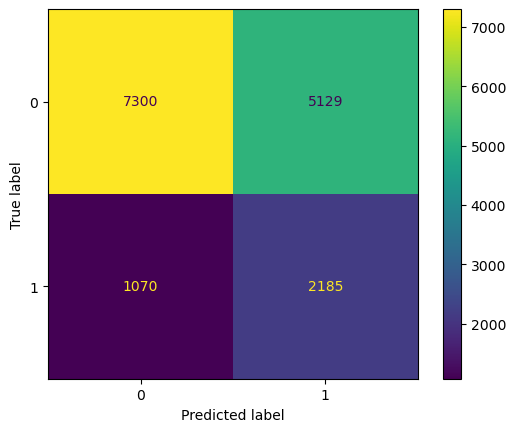

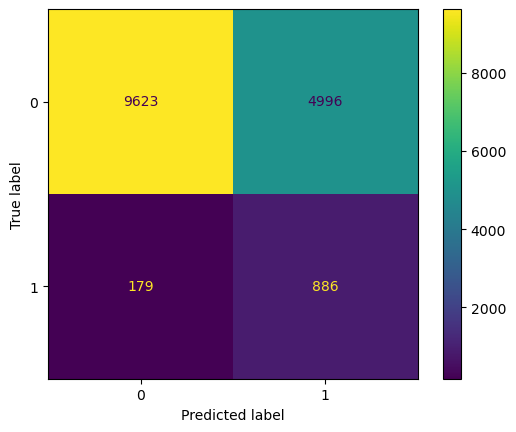

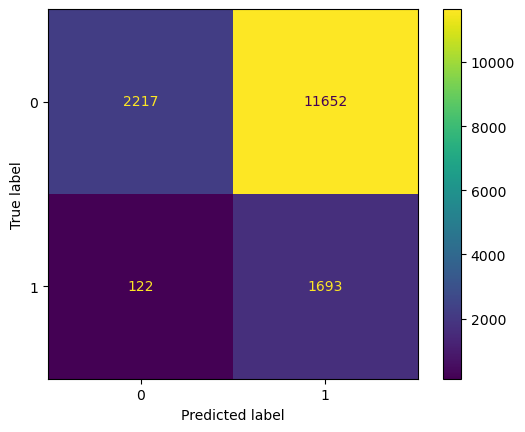

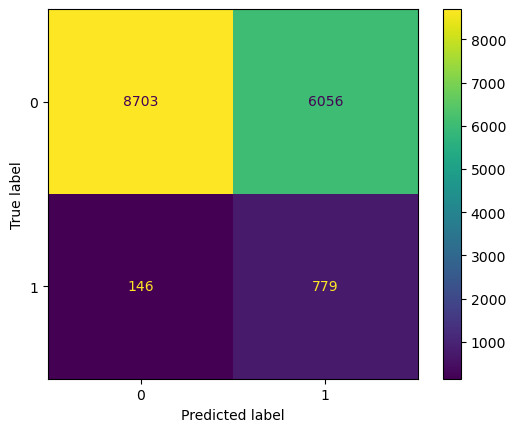

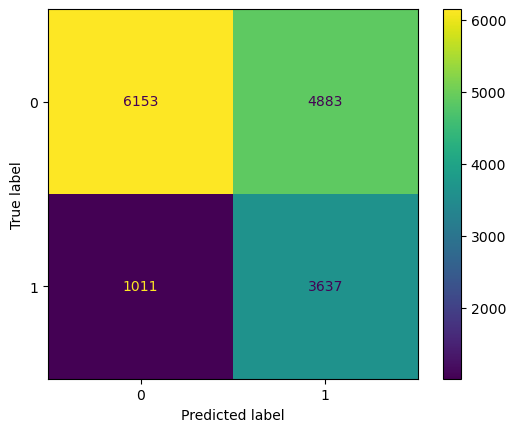

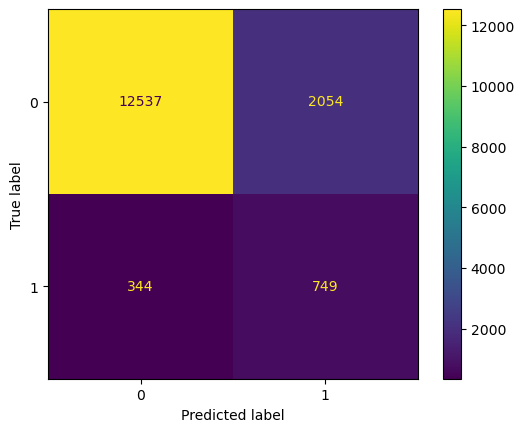

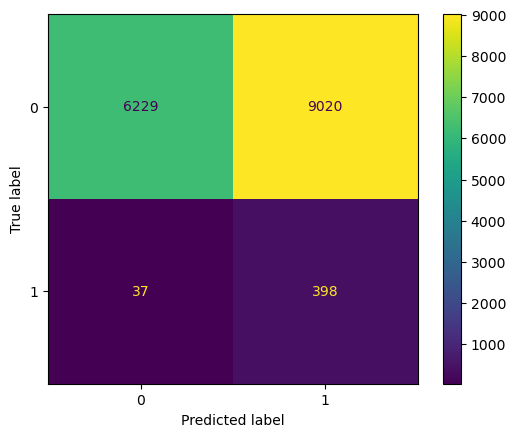

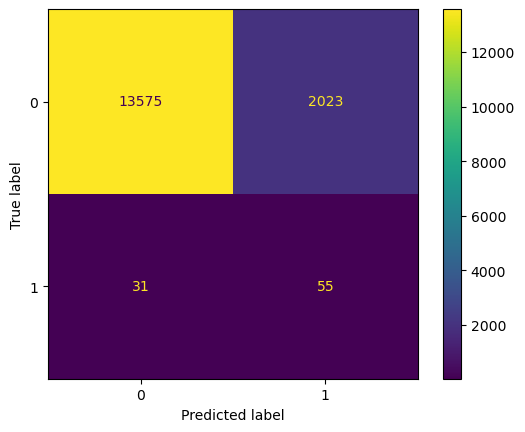

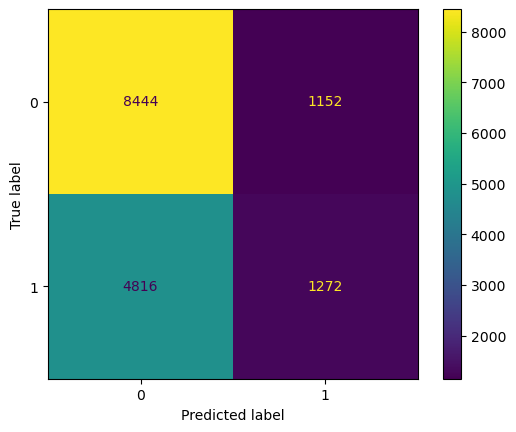

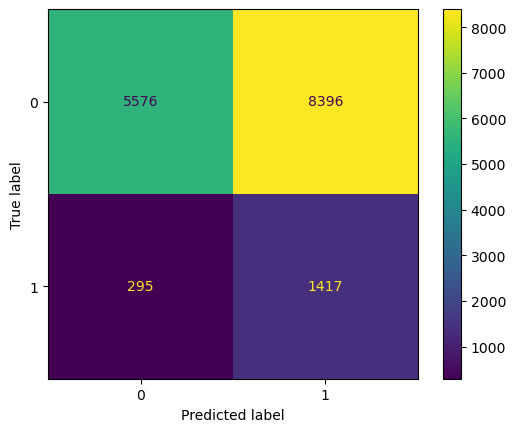

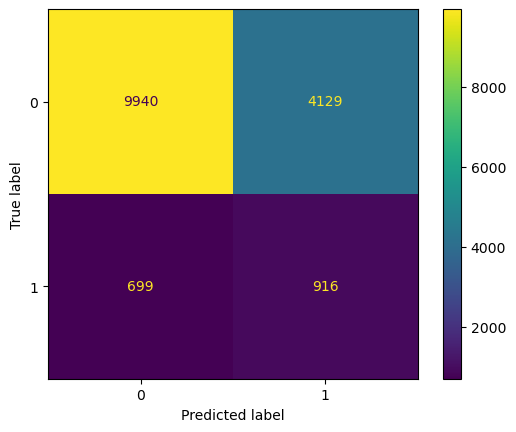

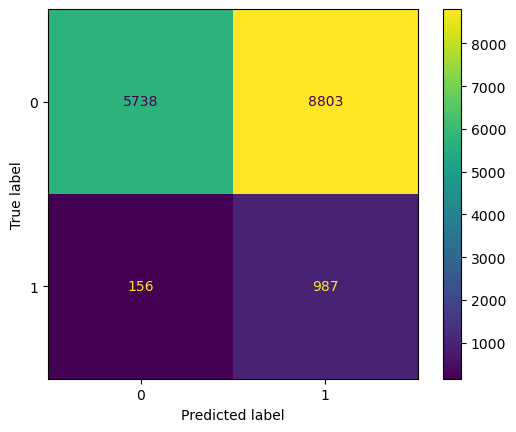

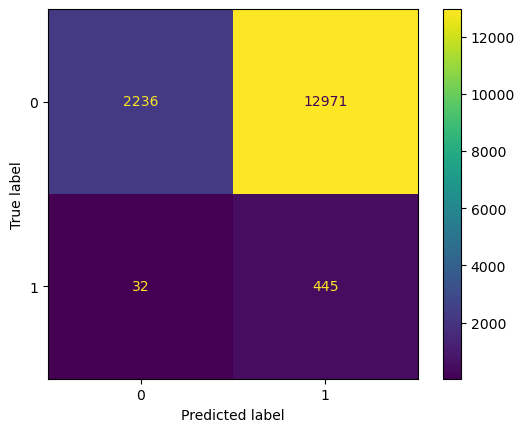

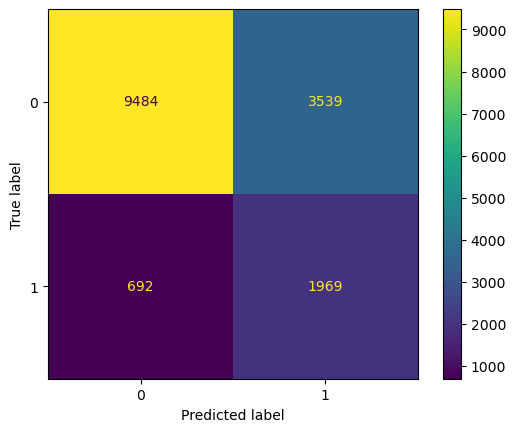

In [43]:
get_classes_accuracy_and_pr(test_loader, vgg)

In [ ]:
# torch.save(class_accuracies_by_epochs, './class_accuracies_by_epochs.pt')
# torch.save(mean_accuracies_by_epochs, './mean_accuracies_by_epochs.pt')

In [49]:
print(len(class_accuracies_by_epochs))
labels

10


['mass',
 'hernia',
 'cardiomegaly',
 'pneumonia',
 'pleural_thickening',
 'atelectasis',
 'infiltration',
 'effusion',
 'pneumothorax',
 'nodule',
 'edema',
 'fibrosis',
 'consolidation',
 'emphysema']

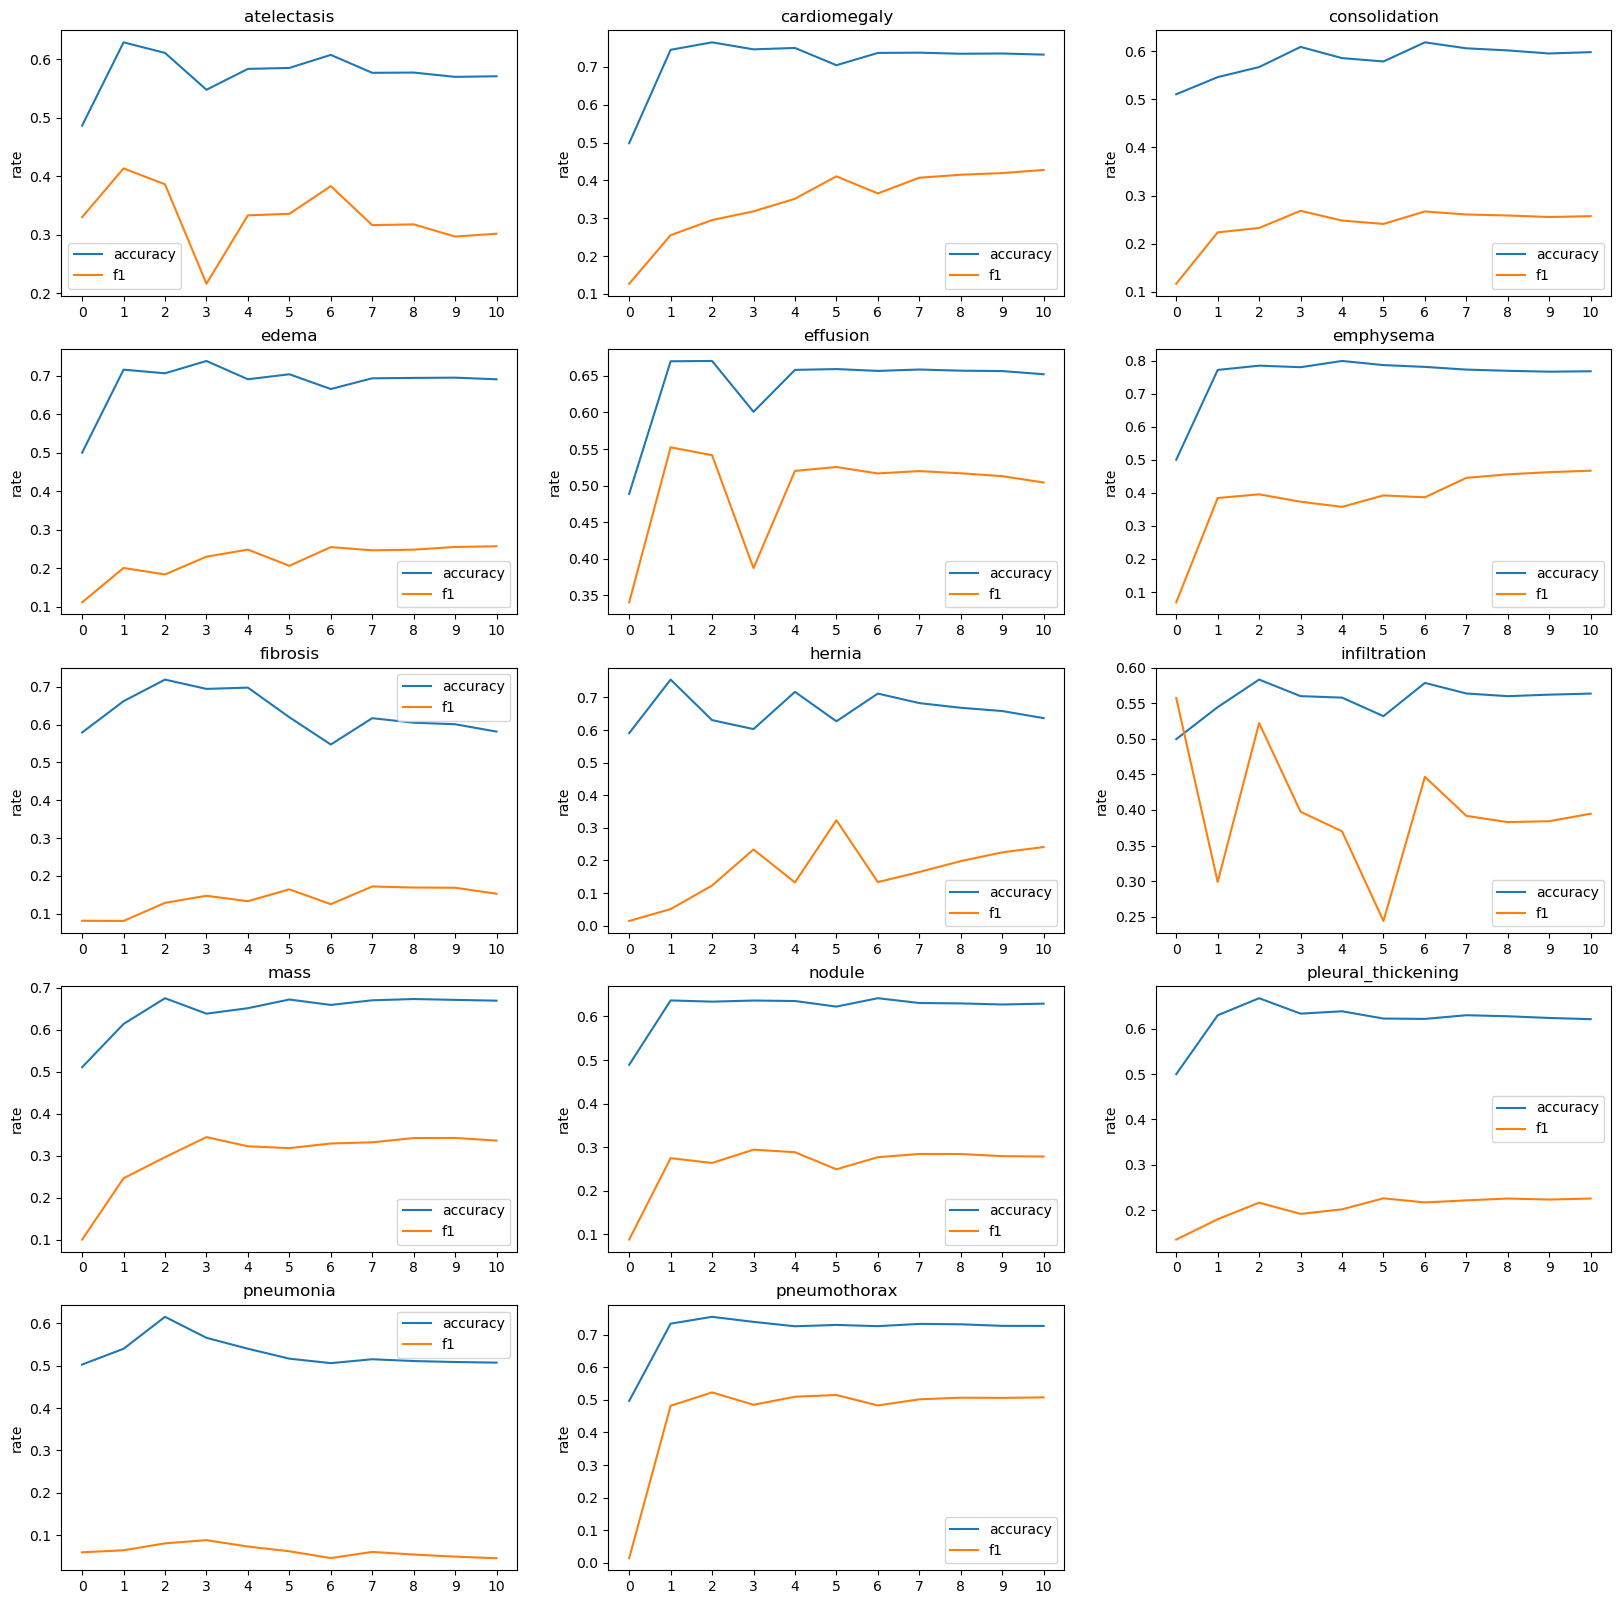

In [135]:
# from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
for i in range(14):
    plt.subplot(5, 3, i + 1)
    plt.plot(range(len(vgg_class_accs) + 1), np.array([np.array(class_accuracies_pretrained_vgg), *vgg_class_accs])[:, i], label='accuracy')
    plt.plot(range(len(vgg_class_f1) + 1), np.array([np.array(f1_pretrained_vgg), *vgg_class_f1])[:, i], label='f1')
    plt.legend()
#     plt.plot(range(1, 11), np.array(class_accuracies_by_epochs)[:, i])
    plt.xticks(ticks=range(len(vgg_class_accs) + 1))
    plt.title(labels[i])
#     plt.xlabel('epoch')
    plt.ylabel('rate')

Text(0, 0.5, 'rate')

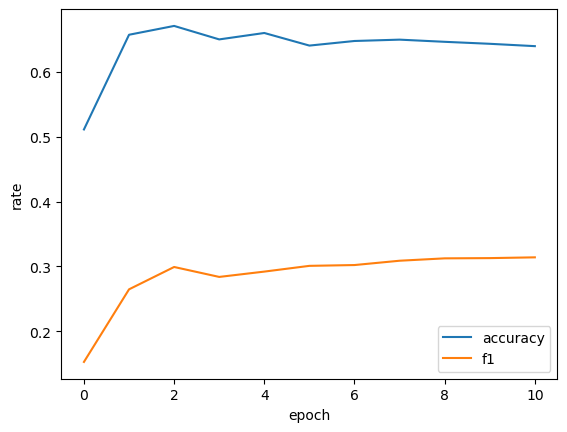

In [145]:
plt.plot(range(len(vgg_mean_accs) + 1),
         [np.mean(class_accuracies_pretrained_vgg), *vgg_mean_accs], label='accuracy')
plt.plot(range(len(vgg_mean_accs) + 1),
         [np.mean(f1_pretrained_vgg), *vgg_mean_f1], label='f1')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('rate')